In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
import torch

from utils.data_transform import Sentinel2Transform
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader

In [2]:
from torch.optim import Adam
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn import NLLLoss
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

from utils import train_valid_eval_utils as tveu
import shutil

# Data Download

In [ ]:
from radiant_mlhub import Dataset

os.environ['MLHUB_API_KEY'] = '380ab1acf08f82cddc417ddaf61b6acbaceb0e6a125435e63b79d93efe0110c6'

if not os.path.exists('data/'):
    os.makedirs('data/')

In [1]:
dataset = Dataset.fetch('dlr_fusion_competition_germany')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

NameError: name 'Dataset' is not defined

In [3]:
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'
brandenburg_te_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/vector_labels.geojson'

In [4]:
brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_tr_labels)))
brandenburg_tr_labels.info()
brandenburg_tr_labels.tail()

INFO: Number of fields: 2534

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2534 non-null   int64   
 1   SHAPE_AREA  2534 non-null   float64 
 2   SHAPE_LEN   2534 non-null   float64 
 3   crop_id     2534 non-null   int64   
 4   crop_name   2534 non-null   object  
 5   geometry    2534 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 118.9+ KB


,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
2529,210145,259644.80075,2922.908013,5,Corn,"MULTIPOLYGON (((451162.920 5809950.180, 451386..."
2530,210149,11260.80940,433.843678,2,Rye,"MULTIPOLYGON (((452645.460 5809120.610, 452645..."
2531,210174,593211.62605,3766.251880,5,Corn,"MULTIPOLYGON (((451948.160 5827166.390, 451948..."
2532,210179,48034.13890,1210.785843,9,Forage Crops,"MULTIPOLYGON (((439830.770 5808003.000, 439881..."
2533,210180,428209.99690,3885.101917,6,Oil Seeds,"MULTIPOLYGON (((437976.290 5828007.960, 437952..."


In [5]:
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))

INFO: Label IDs: [9 1 8 2 3 5 6 7 4]
INFO: Label Names: ['Forage Crops' 'Wheat' 'Meadows' 'Rye' 'Barley' 'Corn' 'Oil Seeds'
 'Root Crops' 'Oats']


INFO: Number of Fields by Crop Type: 
Meadows         954
Forage Crops    339
Wheat           305
Rye             279
Corn            251
Oil Seeds       201
Barley          137
Oats             45
Root Crops       23
Name: crop_name, dtype: int64


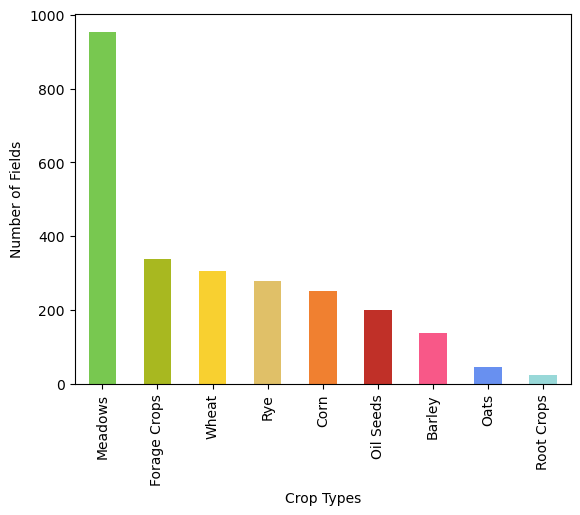

In [6]:
value_counts=brandenburg_tr_labels['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

# Exploring S2 Data

In [13]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018"

In [65]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_data_indices = range(143) #beware that S2 data is not daily, 

#Initialize data reader for planet images
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir,
                                  label_dir=brandenburg_tr_labels_dir,
                                  selected_time_points=selected_data_indices)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 10439.69it/s]


# Working with Sentinel 2 Data

In [36]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

In [61]:
import numpy as np

# Load the .npz file
data = np.load("data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/fid_210180.npz")

# Check the available data indices
print(data.files)
# available_indices = data['image_stack']
print(len(data['image_stack']))
# print("Available data indices:", available_indices)


['image_stack', 'cloud_stack', 'mask', 'feature']
144


In [74]:
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')

def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

def endvi(X):
    B8 = X[7]
    B4 = X[3]
    B2 = X[1]
    return 2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))

In [37]:
# Selected_time_interval can be left empty to exploit all available time points
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir)

crop_id, crop_name = label_ids[7], label_names[0]

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 9999.76it/s] 


In [82]:
# Print Median value of each field for all days
median = []
days = []
iterable = iter(s2_reader)
while True:
    X, y, mask, _ = next(iterable)

    width = X.shape[-1]
    height = X.shape[-2]

    if y == crop_id and width > 60 and height > 60:
        for day in range(143):
            median.append(np.median(ndvi(X[day])))
            days.append(day)

        break

<function matplotlib.pyplot.show(close=None, block=None)>

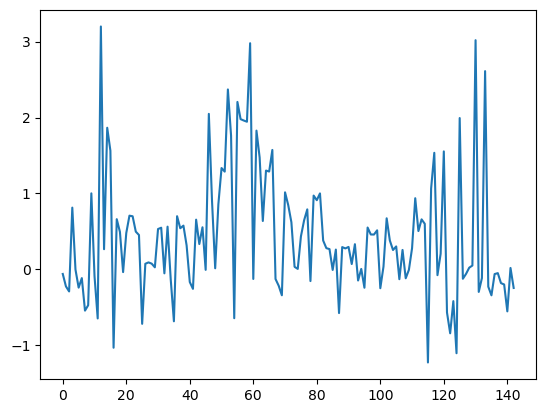

In [81]:
plt.plot(days, median)
plt.show

# Preparing Sentinel 2 data

In [3]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

In [4]:
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]

In [5]:
sentinel_2_transformer=Sentinel2Transform()
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir, label_ids=label_ids, transform=sentinel_2_transformer.transform, min_area_to_ignore=1000)

data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 9009.95it/s]


In [6]:
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

INFO: Training data loader initialized.
INFO: Validation data loader initialized.


In [7]:
torch.cuda.is_available()

True

# CNN LSTM Model

In [10]:
import models
import importlib

importlib.reload(models)

INPUT_DIM = 12
#sequence lenth = 144 total?
SEQUENCE_LENGTH=50
DEVICE='cuda'
START_EPOCH=0
TOTAL_EPOCH=10

# models.test()

brandenburg_model = models.SpatiotemporalModel(input_dim=INPUT_DIM, num_classes=len(label_ids), device=DEVICE)
print(brandenburg_model)

INFO: model initialized with name:Conv2d_LSTM
SpatiotemporalModel(
  (spatial_encoder): SpatialEncoder(
    (model): Sequential(
      (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): AdaptiveAvgPool2d(output_size=(1, 1))
    )
  )
  (temporal_encoder): TemporalEncoder(
    (model): LSTM(16, 9, batch_first=True)
  )
)


In [11]:
optimizer = SGD(brandenburg_model.parameters(), lr=1e-3, momentum=0.9,nesterov=False)
loss_criterion = CrossEntropyLoss()

In [12]:
# Logging results
log = list()
log_root='temp_s2/'
logdir = os.path.join(log_root, brandenburg_model.modelname)
os.makedirs(logdir, exist_ok=True)
print("INFO: Logging results will be saved to {}".format(logdir))
summarywriter = SummaryWriter(log_dir=logdir)
snapshot_path = os.path.join(logdir, "model.pth.tar")

INFO: Logging results will be saved to temp_s2/Conv2d_LSTM


In [13]:
# Resume training if stopped midway ?
snapshot_path = os.path.join(logdir, "model.pth.tar")
if os.path.exists(snapshot_path):
    checkpoint = torch.load(snapshot_path)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    brandenburg_model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {snapshot_path}, epoch {START_EPOCH}")

INFO: Resuming from temp_s2/Conv2d_LSTM\model.pth.tar, epoch 2


In [14]:
for epoch in range(START_EPOCH, TOTAL_EPOCH):
    train_loss = tveu.train_epoch(brandenburg_model, optimizer, loss_criterion, train_loader, device=DEVICE)
    valid_loss, y_true, y_pred, *_ = tveu.validation_epoch(brandenburg_model, loss_criterion, valid_loader, device=DEVICE)
    
    
    scores = tveu.metrics(y_true.cpu(), y_pred.cpu())
    
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    
    valid_loss = valid_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]

    scores["epoch"] = epoch
    scores["train_loss"] = train_loss
    scores["valid_loss"] = valid_loss
    log.append(scores)

    summarywriter.add_scalars("losses", dict(train=train_loss, valid=valid_loss), global_step=epoch)
    summarywriter.add_scalars("metrics",
                              {key: scores[key] for key in
                               ['accuracy', 'kappa', 'f1_micro', 'f1_macro', 'f1_weighted', 
                                'recall_micro','recall_macro', 'recall_weighted', 
                                'precision_micro', 'precision_macro','precision_weighted']},
                                global_step=epoch)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred.cpu().detach().numpy(), labels=np.arange(len(label_ids)))
    summarywriter.add_figure("confusion_matrix",tveu.confusion_matrix_figure(cm, labels=label_ids),global_step=epoch)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv(os.path.join(logdir, "train_log.csv"))

    torch.save(dict( model_state=brandenburg_model.state_dict(),optimizer_state=optimizer.state_dict(), epoch=epoch, log=log),snapshot_path)
    if len(log) > 2:
        if valid_loss < np.array([l["valid_loss"] for l in log[:-1]]).min():
            best_model = snapshot_path.replace("model.pth.tar","model_best.pth.tar")
            print(f"INFO: New best model with valid_loss {valid_loss:.2f} at {best_model}")
            shutil.copy(snapshot_path, best_model)

    print(f"INFO: epoch {epoch}: train_loss {train_loss:.2f}, valid_loss {valid_loss:.2f} " + scores_msg)

valid loss=2.05: 100%|██████████| 79/79 [00:16<00:00,  4.90it/s]


INFO: epoch 2: train_loss 1.80, valid_loss 1.86 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.92: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


INFO: epoch 3: train_loss 1.75, valid_loss 1.95 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.92: 100%|██████████| 79/79 [00:12<00:00,  6.54it/s]


INFO: epoch 4: train_loss 1.96, valid_loss 1.91 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.84: 100%|██████████| 79/79 [00:12<00:00,  6.54it/s]


INFO: epoch 5: train_loss 1.92, valid_loss 1.89 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.81: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]


INFO: epoch 6: train_loss 1.86, valid_loss 1.88 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.82: 100%|██████████| 79/79 [00:11<00:00,  6.63it/s]


INFO: epoch 7: train_loss 1.83, valid_loss 1.90 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.82: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


INFO: epoch 8: train_loss 1.83, valid_loss 1.89 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


valid loss=1.86: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]

INFO: epoch 9: train_loss 1.80, valid_loss 1.88 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15
